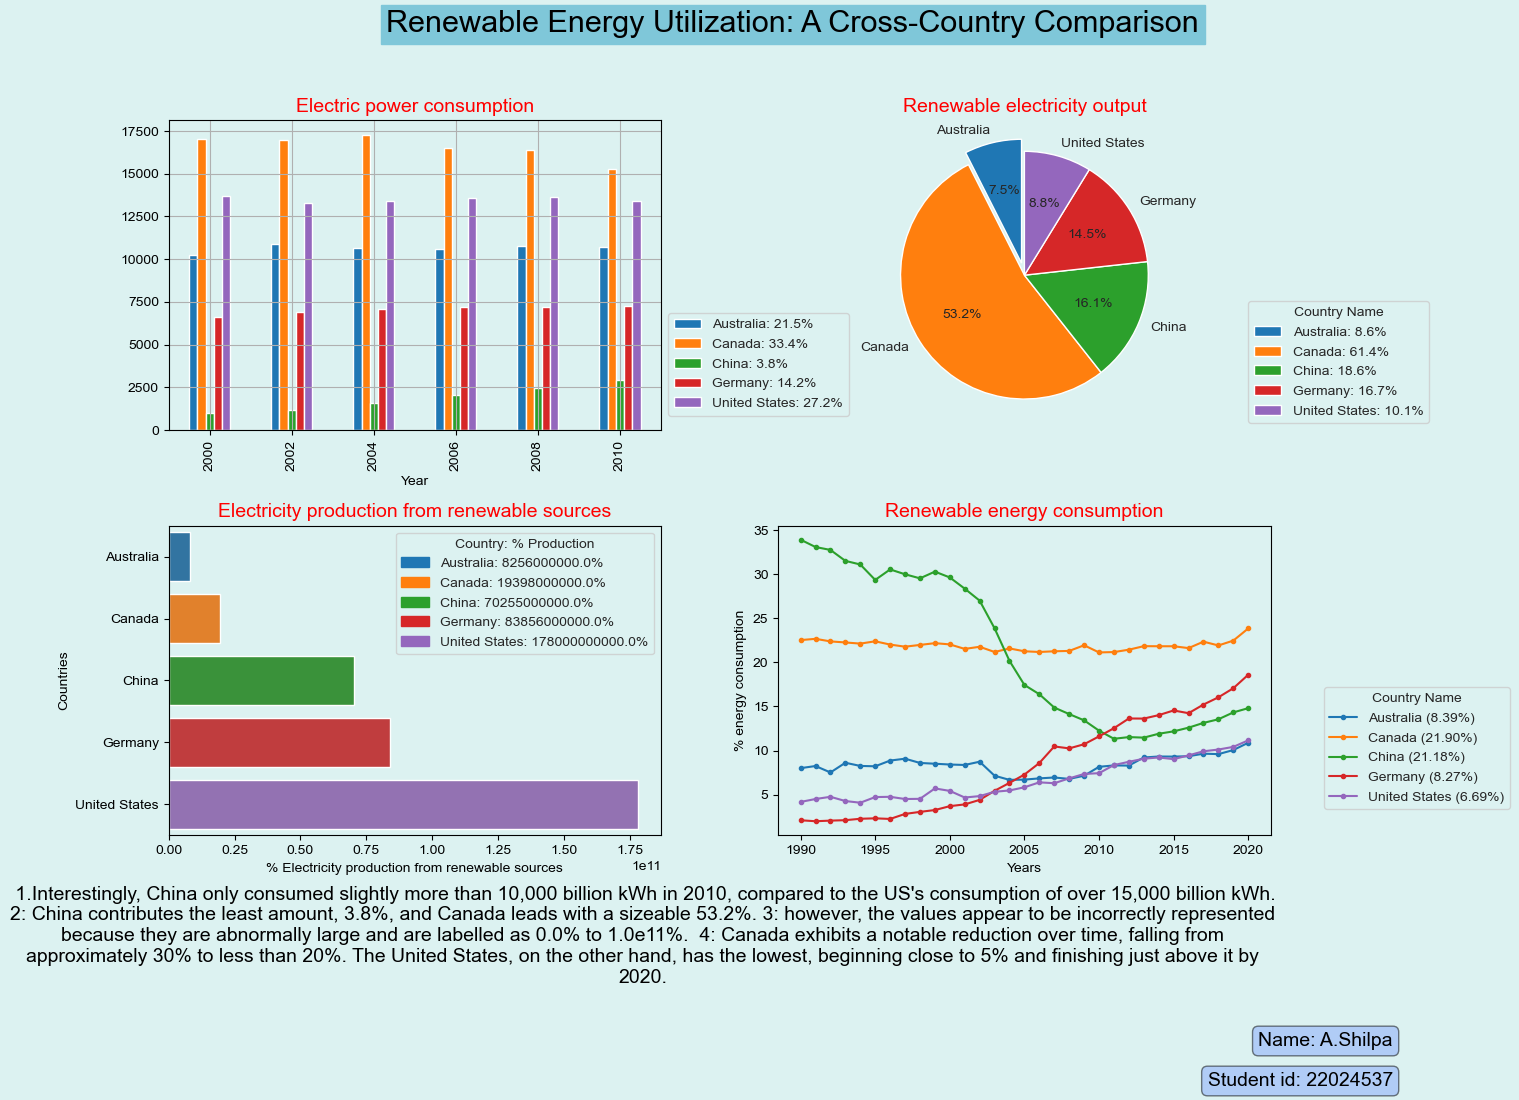

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from scipy.stats import gaussian_kde
import textwrap


def read_and_prepare_data(file_path):
    """
    Read data from a CSV file and prepare it for analysis.

    Parameters:
    - file_path (str): Path to the CSV file.

    Returns:
    - pd.DataFrame: Melted data frame with columns 'Indicator Name', 'Country Name', 'Year', and 'Value'.
    """
    data = pd.read_csv(file_path)
    data_melted = data.melt(id_vars = ['Indicator Name', 'Country Name'], var_name = 'Year', value_name = 'Value')
    data_melted['Year'] = data_melted['Year'].astype(int)
    return data_melted


def prepare_data(data, indicator, countries, year = None, reset_index = False):
    """
    Prepare data for plotting based on specified indicators, countries, and optional filters.

    Parameters:
    - data (pd.DataFrame): Melted data frame with columns 'Indicator Name', 'Country Name', 'Year', and 'Value'.
    - indicator (str): Indicator name to filter the data.
    - countries (list): List of country names to include in the plot.
    - year (int, optional): Filter data for a specific year.
    - reset_index (bool, optional): Reset index of the resulting data frame.

    Returns:
    - pd.DataFrame: Pivot table with relevant data for plotting.
    """
    data_filtered = data[(data['Country Name'].isin(countries)) & (data['Indicator Name'] == indicator)]
    if year:
        data_filtered = data_filtered[data_filtered['Year'] == year]
    data_pivot = data_filtered.pivot(index = 'Year', columns = 'Country Name', values = 'Value')
    if reset_index:
        data_pivot = data_pivot.reset_index()
    return data_pivot


def plot_electric_power_consumption(ax, df, colors):
    """
    Plot electric power consumption over selected years for multiple countries.

    Parameters:
    - ax (matplotlib.axes._subplots.AxesSubplot): Axes to plot on.
    - df (pd.DataFrame): Data frame with electric power consumption values for different countries and years.
    - colors (list): List of colors for the bar plot.

    Returns:
    displays bar chart
    """
    selected_years = [year for year in range(2000, 2011, 2)]
    df_selected = df.loc[selected_years]

    # Plotting
    df_selected.plot(kind = 'bar', ax = ax, color = colors)

    ax.set_title('Electric power consumption', fontsize = 14, color = 'red')
    ax.set_facecolor('#DCF2F1')

    total_consumption = df_selected.sum().sum()
    percentages = df_selected.sum() / total_consumption * 100
    legend_labels = [f"{country}: {percent:.1f}%" for country, percent in zip(df_selected.columns, percentages)]

    ax.legend(legend_labels, loc = 'best', bbox_to_anchor = (1, 0.4), facecolor = '#DCF2F1')
    
    
def plot_renewable_electricity_output(ax, df, colors):
    """
    Plot renewable electricity output using a pie chart for a specific year.

    Parameters:
    - ax (matplotlib.axes._subplots.AxesSubplot): Axes to plot on.
    - df (pd.DataFrame): Data frame with renewable electricity output values for different countries and years.
    - colors (list): List of colors for the pie chart.

    Returns:
    displays pie chart
    """
    values = df.loc[2010].tolist()
    labels = df.columns.tolist()
    explode = (0.1, 0, 0, 0, 0)

    # Plotting the pie chart
    wedges, texts, autotexts = ax.pie(values, labels = labels, startangle = 90, autopct = '%1.1f%%', explode = explode, colors = colors)

    ax.set_title('Renewable electricity output', fontsize = 14, color = 'red')
    ax.set_facecolor('#DCF2F1')

    legend_labels = [f"{label}: {value:.1f}%" for label, value in zip(labels, values)]
    ax.legend(wedges, legend_labels, title = 'Country Name', loc = 'lower left', bbox_to_anchor = (1.2, 0, 1, 1), facecolor = '#DCF2F1')
    
    
def plot_electricity_production(ax, df, colors):
    """
    Plot electricity production from renewable sources using a horizontal bar chart.

    Parameters:
    - ax (matplotlib.axes._subplots.AxesSubplot): Axes to plot on.
    - df (pd.DataFrame): Data frame with electricity production values for different countries.
    - colors (list): List of colors for the bar chart.

    Returns:
    displays horizontal bar chat
    """
    if 'Year' in df.columns:
        df = df.drop(columns = 'Year')

    # Plotting the horizontal bar chart
    barplot = sns.barplot(x = df.iloc[0], y = df.columns, ax = ax, palette = colors)

    ax.set(xlabel = '% Electricity production from renewable sources', ylabel = 'Countries')
    ax.set_facecolor('#DCF2F1')
    ax.set_title('Electricity production from renewable sources', fontsize = 14, color = 'red')

    # Creating legend patches
    legend_patches = [mpatches.Patch(color = color, label = f"{country}: {value:.1f}%") 
                      for country, value, color in zip(df.columns, df.iloc[0], colors)]

    ax.legend(handles = legend_patches, title = 'Country: % Production', loc = 'upper right', bbox_to_anchor = (1, 1), facecolor = '#DCF2F1')

    
def plot_energy_consumption(ax, df, data_melted, colors):
    """
    Plot renewable energy consumption using line charts for each country over time.

    Parameters:
    - ax (matplotlib.axes._subplots.AxesSubplot): Axes to plot on.
    - df (pd.DataFrame): Data frame with renewable energy consumption values for different countries over time.
    - data_melted (pd.DataFrame): Melted data frame with indicator values for all countries and years.
    - colors (list): List of colors for the line charts.

    Returns:
    Displays line chart
    """
    indicator_name = 'Renewable energy consumption (% of total final energy consumption)'

    if 'Year' in df.columns:
        df = df.set_index('Year')

    if not df.empty:
        # Plotting line charts for each country
        for i, country in enumerate(df.columns):
            ax.plot(df.index, df[country], label = f"{country} ({df[country].mean():.2f}%)", color = colors[i], marker = '.')

        ax.set_title('Renewable energy consumption', fontsize=14, color='red')
        ax.set_xlabel('Years')
        ax.set_ylabel('% energy consumption')
        ax.set_facecolor('#DCF2F1')

        # Adding legend with mean values
        averages = data_melted[data_melted['Indicator Name'] == indicator_name].groupby('Country Name')['Value'].mean()
        legend_labels = [f"{country} ({averages[country]:.2f}%)" for country in df.columns]

        ax.legend(title = 'Country Name', loc = 'upper right', bbox_to_anchor = (1.5, 0.5), facecolor = '#DCF2F1')
    else:
        ax.text(0.5, 0.5, 'No data available', horizontalalignment = 'center', verticalalignment = 'center', fontsize = 12)
        ax.set_facecolor('#DCF2F1')
        ax.set_title('Renewable energy consumption', fontsize = 14)
        
        
def generate_plots(df_electric_power_consumption, df_renewable_electricity_output, df_electricity_production, df_energy_consumption, colors):
    """
    Generate subplots for each type of renewable energy-related data.

    Parameters:
    - df_electric_power_consumption (pd.DataFrame): Electric power consumption data frame.
    - df_renewable_electricity_output (pd.DataFrame): Renewable electricity output data frame.
    - df_electricity_production (pd.DataFrame): Electricity production from renewable sources data frame.
    - df_energy_consumption (pd.DataFrame): Renewable energy consumption data frame.
    - colors (list): List of colors for the plots.

    Returns:
    - fig (matplotlib.figure.Figure): Generated figure.
    """
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10), facecolor = '#DCF2F1')
    sns.set_style("whitegrid")

    plot_electric_power_consumption(axes[0, 0], df_electric_power_consumption, colors)
    plot_renewable_electricity_output(axes[0, 1], df_renewable_electricity_output, colors)
    plot_electricity_production(axes[1, 0], df_electricity_production, colors)
    plot_energy_consumption(axes[1, 1], df_energy_consumption, data_melted, colors)
    plt.suptitle("Renewable Energy Utilization: A Cross-Country Comparison", fontsize = 22, y = 0.98, color = 'black', ha = 'center', backgroundcolor = '#7FC7D9')

    return fig

# Main execution code
file_path = "world-data.csv" 
data_melted = read_and_prepare_data(file_path)
country_list = ['Australia', 'Canada', 'China', 'Germany', 'United States']
df_electric_power_consumption = prepare_data(data_melted, 'Electric power consumption (kWh per capita)', country_list)
df_renewable_electricity_output = prepare_data(data_melted, 'Renewable electricity output (% of total electricity output)', country_list, year=2010)
df_electricity_production = prepare_data(data_melted, 'Electricity production from renewable sources, excluding hydroelectric (kWh)', country_list, year=2010, reset_index=True)
df_energy_consumption = prepare_data(data_melted, 'Renewable energy consumption (% of total final energy consumption)', country_list, reset_index=True)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Generating the plots
fig = generate_plots(df_electric_power_consumption, df_renewable_electricity_output, df_electricity_production, df_energy_consumption, colors)


# Define the report text
report_text = """ 1.Interestingly, China only consumed slightly more than 10,000 billion kWh in 2010, compared to the US's consumption of over 15,000 billion kWh.
2: China contributes the least amount, 3.8%, and Canada leads with a sizeable 53.2%.
3: however, the values appear to be incorrectly represented because they are abnormally large and are labelled as 0.0% to 1.0e11%. 
4: Canada exhibits a notable reduction over time, falling from approximately 30% to less than 20%. The United States, on the other hand, has the lowest, beginning close to 5% and finishing just above it by 2020.
"""

# Adding the report text at the bottom of the figure
text_y_position = -0.01  
fig.text(0.4, 0.01, textwrap.fill(report_text , width=145), horizontalalignment='center', fontsize=14, color='black', wrap=True)

# Stylish box for author information at the bottom right corner
author_box = dict(boxstyle = 'round', facecolor = '#86A7FC', alpha = 0.5, edgecolor = 'black')
fig.text(0.90, -0.06, "Name: A.Shilpa", ha = "right", va = "bottom", fontsize = 14, color = 'black', bbox = author_box)
fig.text(0.90, -0.10, "Student id: 22024537", ha = "right", va = "bottom", fontsize = 14, color = 'black', bbox = author_box)

# Adjusting layout to make room for the text below the plots
plt.tight_layout(rect = [0, 0.1, 1, 0.95])

# Show the figure
plt.show()
